## Naive MCMC for Estimating Parameters for a Single-Jump Diffusion Model


Assumes that:
+ log price change before the jump follows a Gaussian
+ log price change during the jump follows a Gaussian
+ no. of time steps of the jump is in the interval [1, $\infty$] with strong preference for (0, 10) with very low probability for values greater than 10

More formally, the $i$-th price index at time $t + 1$, $p_i$, can be described by the following:

$$
\begin{align*}
    p_i(t + 1)  &= p_{i}(t) x(t),\\
    p_i(0)      &= 1,\\\\

    \log x(t)        &\sim\begin{cases}\mathcal{N}(\mu_j, \sigma_j^2), & \text{if } s \le t < s + n_i, \\\mathcal{N}(\mu_i, \sigma_i^2), & \text{otherwise,}\end{cases}\\\\
    \mu_i       &\overset{iid}{\sim} \mathcal{B}(1 \times 10^1, 1 \times 10^3) - 0.005,\\
    \sigma_i    &\overset{iid}{\sim} \mathcal{U}(0, 0.05),\\\\
    \mu_j       &\overset{iid}{\sim} \mathcal{B}(1 \times 10^4, 1 \times 10^5),\\
    \sigma_j    &\overset{iid}{\sim} \mathcal{B}(1 \times 10^4, 1 \times 10^6),\\\\

    n_i         &\sim \mathcal{P}(2.5) + 1
\end{align*}
$$

where $\mathcal{N},\ \mathcal{B},\ \mathcal{U},$ and $\mathcal{P}$ are the Normal, Beta, Uniform, and Poisson distributions respectively and

+ $n_i$ is the number of time steps the jump lasts for the $i$-th price index
+ $s$ is the time when the jump process starts (fixed for all assets)
+ $\mu_i$ is the mean drift for the $i$-th price index in log space
+ $\sigma_i^2$ is the variance for the $i$-th price index in log space
+ $\mu_j$ is the mean drift for all assets during their jump process
+ $\sigma_j^2$ is the variance for all assets during their jump process

In [1]:
from   matplotlib   import pyplot as plt
from   scipy        import stats

import numpy as np

In [2]:
# M assets with different drifts, volatility and number of time steps for the jump process
M  = 10

np.random.seed(0)

# draw the asset parameters randomly from sensible looking distributions
mu = stats.beta(1e1, 1e3).rvs(M) - 5e-3
sd = stats.uniform(0, 5e-2).rvs(M)
nt = stats.poisson(2.5    ).rvs(M) + 1

# jump parameters (shared amongst all assets)
mu_j, sd_j = stats.beta(1e4, 1e5).rvs(), stats.beta(1e4, 1e6).rvs()

# solution and two text formats
solution = np.array(sum([list(msn) for msn in zip(mu, sd, nt)], []) + [mu_j, sd_j])
string   = sum([[f' mu_{i}', f' sd_{i}', f'lam_{i}'] for i in range(1, len(mu) + 1)], []) + [' mu_j', ' sd_j']
latex    = sum([[ r'$\mu_' f'{i}$', r'$\sigma_' f'{i}$', r'$\lambda_' f'{i}$'] for i in range(1, len(mu) + 1)], []) + ['$\mu_j$', '$\sigma_j$']

# solution with the sd values in log10 space (optimisation later in log10 space)
log_space = solution.copy()
log_space[1::3] = np.log10(log_space[1::3])

# number of time periods before the jump for each asset
start = 100

def generator(mu, sd, nt, mu_j, sd_j, start = start, after = 20):

    T          = start + nt + after

    mask       = [(start <= i < start + nt) for i in range(T)]

    jump       = np.zeros(T, dtype = float)
    jump[mask] = np.random.normal(mu_j, sd_j, size = nt)

    vol        = np.random.normal(mu  , sd  , size =  T)
    vol[0]     = 0
    vol[mask]  = 0

    index      = np.exp(jump + vol)
    index      = index.cumprod()

    return index, vol, jump

index, vol, jump = [], [], []

for k, (m, s, n) in enumerate(zip(mu, sd, nt)):
    i, v, j = generator(m, s, n, mu_j, sd_j)
    index.append(i)
    vol.append(v)
    jump.append(j)

# truncate to the smallest length (still includes the entire jump period)
min_length       = min(map(len, index))
index, vol, jump = map(lambda arrays : np.array([array[:min_length] for array in arrays]), [index, vol, jump])

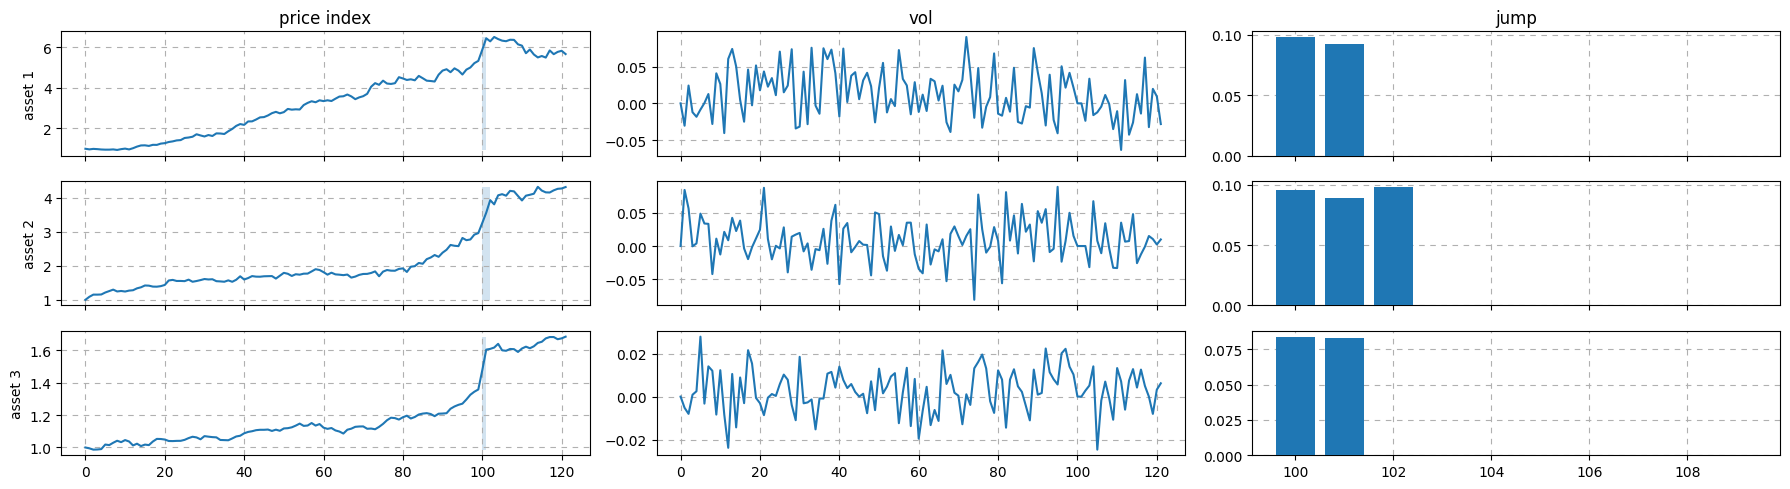

In [3]:
# visualise the first three assets
fig, ax = plt.subplots(3, 3, figsize = (18, 5), sharex = 'col')

for j, title in enumerate(['price index', 'vol', 'jump']):
        ax[0, j].set_title(title)

ymin, ymax = index[:3].min(axis = 1), index[:3].max(axis = 1)
for i, (ind, v, j, m, n) in enumerate(zip(index, vol, jump, mu, nt)):
    ax[i, 0].plot(ind)
    ax[i, 0].fill_betweenx([ymin[i], ymax[i]], start, start + n - 1, alpha = 0.2)
    ax[i, 0].set_ylabel(f'asset {i + 1}')

    ax[i, 1].plot(v)

    ax[i, 2].bar(range(100, 110), j[start:start + 10], zorder= 3)

    for j in range(3):
        ax[i, j].grid(ls = (0, (5, 5)))

    if i == 2:
        break

plt.tight_layout()

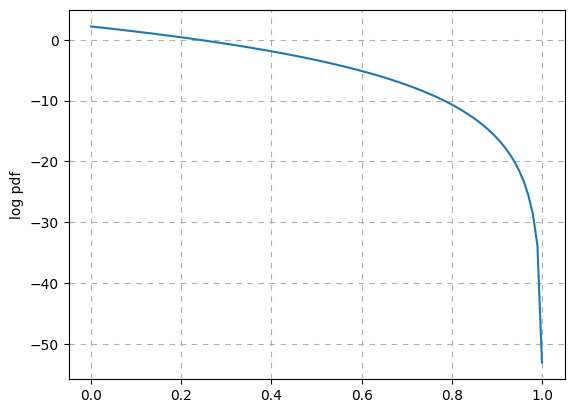

In [4]:
# Choice of priors

# Lets assume a Uniform prior for the jump period in the interval [1, 8]
# Lets assume a Uniform prior for the standard deviations in the interval [0, 0.1]
# ideally both should be more complicated than a Uniform but I choose this for simplicity

# Lets assume a beta prior for log jump returns per time period (mu_j)
xm = np.linspace(0.001, 0.999, 100)

plt.plot(xm, stats.beta(1, 9).logpdf(xm))
plt.ylabel('log pdf')

plt.grid(ls = (0, (5, 5)))

# we prefer a jump drift  towards 0 and increasingly becomes less likely away from 0 
# (bounded, as we further assume price cannot double per time period)

In [5]:
def log_data_likelihood(x, data, start):
    mu, log_sd, lam, mu_j, log_sd_j = x[0:-2:3], x[1:-2:3], x[2:-2:3], x[-2], x[-1]

    sd, sd_j   = 10 ** log_sd, 10 ** log_sd_j

    nt         = [int(l + 0.5) for l in lam] # rounds each lam value to the nearest integer

    # log of relative price difference
    p          = np.log(np.insert((data[:,1:] / data[:,:-1]), 0, 1, 1))

    # masks for jump and vol period (per asset)
    mask_jump  = np.zeros_like(p, dtype = bool)
    mask_vol   = np.zeros_like(mask_jump)
    
    # each asset has a different jump mask due to a different nt
    for i, n in enumerate(nt):
        mask_jump[i,start:start + n] = True
        mask_vol[i,:start]           = True

    # log probabilities
    p_j, p_v = 0, 0
    for i, m in enumerate(mu):
        p_j += stats.norm.logpdf(p[i,mask_jump[i]], mu_j, sd_j ).sum() # same jump parameter applied to all asset indexes
        p_v += stats.norm.logpdf(p[i,mask_vol [i]], m   , sd[i]).sum() # independent gaussian for each asset

    # return total log probability
    return p_j + p_v

def log_prior(x, **kwargs):
    mu, log_sd, lam, mu_j, log_sd_j = x[0:-2:3], x[1:-2:3], x[2:-2:3], x[-2], x[-1]

    sd, sd_j   = 10 ** log_sd, 10 ** log_sd_j

    # lazy prior on the mean jump period to be U(1, 11)
    p_lam  = -np.inf if any((lam < 1) | (lam > 11  )) else len(lam) * np.log(0.1)

    sd     = np.append(sd, sd_j)

    # lazy prior on all sd values to be U(0, 0.1)
    p_sd   = -np.inf if any((sd  < 0) | (sd  > 0.1)) else len(sd ) * np.log(10)
    
    # beta prior as shown in the previous cell
    p_mu_j = stats.beta(1, 9).logpdf(mu_j)

    return p_lam + p_mu_j + p_sd

def log_pstar(x, **kwargs):
    # p(theta|data) = p(data|theta) p(theta) / c 
    # for some normalising constant c (hence ignored)
    return log_data_likelihood(x, **kwargs) + log_prior(x)

def gibbs(log_pstar, theta0, n, burn = 0.2, cov = 0.01, random_state = None, **kwargs):

    # number of elements in a sample
    m       = len(theta0)
    
    # ensures cov is a vector of variances
    if isinstance(cov, (int, float)):
        cov = [cov] * m
    elif cov.ndim == 2:
        # ignore covariances and only use the diagonal variance terms
        cov = np.diag(cov)
    else:
        cov = cov.copy()

    if random_state is not None:
        # set seed for reproducibility
        np.random.seed(random_state)

    # N is chosen such that n = N - N * burn i.e. if we ignore the burn period we are left with n samples
    N       = int(n / (1 - burn) + 0.5)

    r       = np.zeros((N, m), dtype = bool) # indicator variable for rejection
    samples = []                             # samples to return
    old     = theta0                         # set the previous sample, old, as the initial theta0
    log     = np.zeros((N, m))               # record of pstar values
    log[0]  = log_pstar(old, **kwargs)       # assign the first row of pstar values to pstar(old)
    ind     = (0, 0)                         # index of the most current accepted sample
    for i in range(1, N):
        for j in range(m):

            # copy the old sample
            new    = old.copy()

            # only sample the j-th element
            new[j] = stats.norm(new[j], cov[j]).rvs()

            # compute pstar
            l      = log_pstar(new, **kwargs)

            # check if pstar did not explode
            # accept with p_new / p_old probability
            if np.isfinite(l) and ((l > log[ind]) or ((np.random.uniform() < np.exp(l - log[ind])))):
                old      = new
                ind      = (i, j) # location of the most current pstar value to compare with
                log[ind] = l      # assign pstar(new)
            else:

                # rejection counter update
                r[i, j]  += 1

                # set the record of pstar values for the (i, j)-th entry to be pstar(old)
                log[i, j] = log[ind]

        # append sample (note that old has been modified in the inner for-loop)
        samples.append(old)
    
    # samples[n, m], rejection indicator [N, m], pstar(all_samples) [N, m] where N > n due to burn-in
    return np.array(samples[N - n:]), r, log


# mu_1, log_10(sd_1), lam_1, mu_2, log_10(sd_2), lam_2, ..., mu_j, log_10(sd_j)
theta0  = np.array([0.0,-3.0, 1.9] * len(index) + [0.2,-4])

# every parameter of theta0 will change by N(0, 0.1^2) when sampling
cov     = 0.1

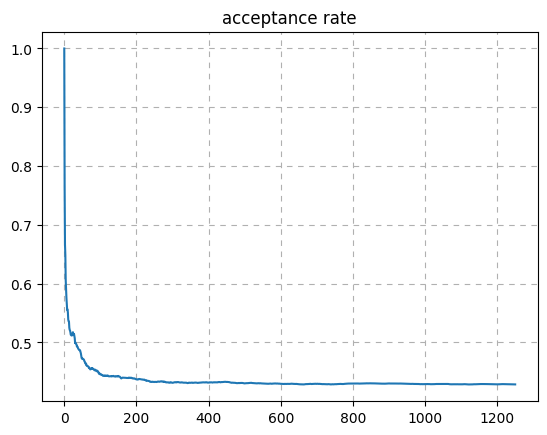

In [6]:
# execute our gibbs sampler with some number of samples, `n`, and a burn-in period, `burn`.
# on my personal (old laptop):
#     takes ~ 2.5 mins with (M, n) = (10, 1000)
#     takes ~10   mins with (M, n) = (75,  100)
# 
# recall `M` is the number of assets at the top of the notebook

n               = 1000
burn            = 0.2
samples, r, log = gibbs(log_pstar, theta0, n, cov = cov, burn = burn, random_state = 0, data = index, start = start)

# average result
average         = samples.mean(axis = 0)

# as we have an acceptance indicator for each element within a sample
# average across the elements within a sample
r = r.mean(axis = 1) 

# visualise acceptance rate
plt.plot(1 - r.cumsum(axis = 0) / np.arange(1, len(r) + 1))
plt.title('acceptance rate')
plt.grid(ls = (0, (5, 5)))
plt.show()

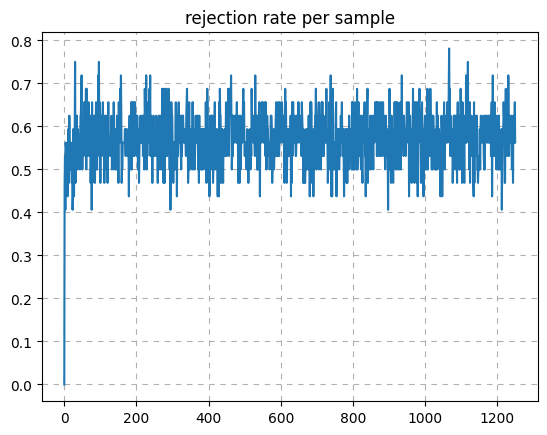

In [7]:
# visualise proportion of elements rejected for each sample
plt.plot(r)
plt.title('rejection rate per sample')
plt.grid(ls = (0, (5, 5)))
plt.show()

# this shows that each complete new sample is different to the previous
# where between 50-60% of the elements are rejected i.e. 40-50% of the
# next sample are different to the previous

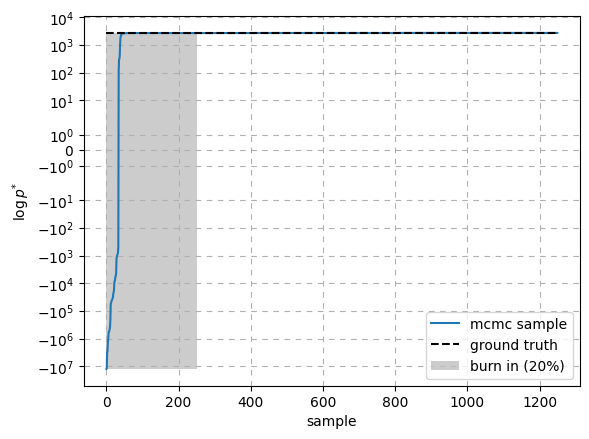

param    |  initial |    truth |  average
---------+----------+----------+---------

 mu_1    |  +0.0000 |  +0.0108 |  +0.0168
 sd_1    |  +0.0010 |  +0.0333 |  +0.0336
lam_1    |  +1.9000 |  +2.0000 |  +2.0310

 mu_2    |  +0.0000 |  +0.0120 |  +0.0109
 sd_2    |  +0.0010 |  +0.0335 |  +0.0331
lam_2    |  +1.9000 |  +3.0000 |  +3.0750

 mu_3    |  +0.0000 |  +0.0041 |  +0.0025
 sd_3    |  +0.0010 |  +0.0105 |  +0.0104
lam_3    |  +1.9000 |  +2.0000 |  +1.9781

 mu_4    |  +0.0000 |  +0.0070 |  +0.0058
 sd_4    |  +0.0010 |  +0.0064 |  +0.0070
lam_4    |  +1.9000 |  +2.0000 |  +2.0866

 mu_5    |  +0.0000 |  +0.0059 |  +0.0024
 sd_5    |  +0.0010 |  +0.0158 |  +0.0141
lam_5    |  +1.9000 |  +2.0000 |  +1.9193

 mu_6    |  +0.0000 |  +0.0100 |  +0.0084
 sd_6    |  +0.0010 |  +0.0182 |  +0.0173
lam_6    |  +1.9000 |  +3.0000 |  +2.9650

 mu_7    |  +0.0000 |  -0.0014 |  -0.0036
 sd_7    |  +0.0010 |  +0.0285 |  +0.0277
lam_7    |  +1.9000 |  +2.0000 |  +1.9172

 mu_8    |  +0.0000 |  +0.

In [8]:
L = log.mean(axis = 1)
plt.plot(L, label = r'mcmc sample')
plt.yscale('symlog')
plt.hlines(log_pstar(log_space, data = index, start = start), 0, len(log) - 1, ls = '--', colors = 'k', label = 'ground truth')
plt.fill_betweenx([L.min(), L.max()], 0, len(log) * burn, fc = 'k', alpha = 0.2, label = f'burn in ({burn:.0%})')
plt.grid(ls = (0, (5, 5)))
plt.xlabel('sample')
plt.ylabel(r'$\log p^{*}$')
plt.legend()

plt.show()

print('param    |  initial |    truth |  average')
print('---------+----------+----------+---------')
for i, (text, truth, theta, element) in enumerate(zip(string, solution, theta0, average)):
    q = i % 3

    # seperate each set of asset parameters
    if q == 0:
        print()

    # convert the sd values from log10 space
    if q == 1:
        theta   = 10 ** theta
        element = 10 ** element    

    print(f'{text:7s}  | {theta:+8.4f} | {truth:+8.4f} | {element:+8.4f}')

# we can observe that we have a lot of samples that are more probable than the ground truth

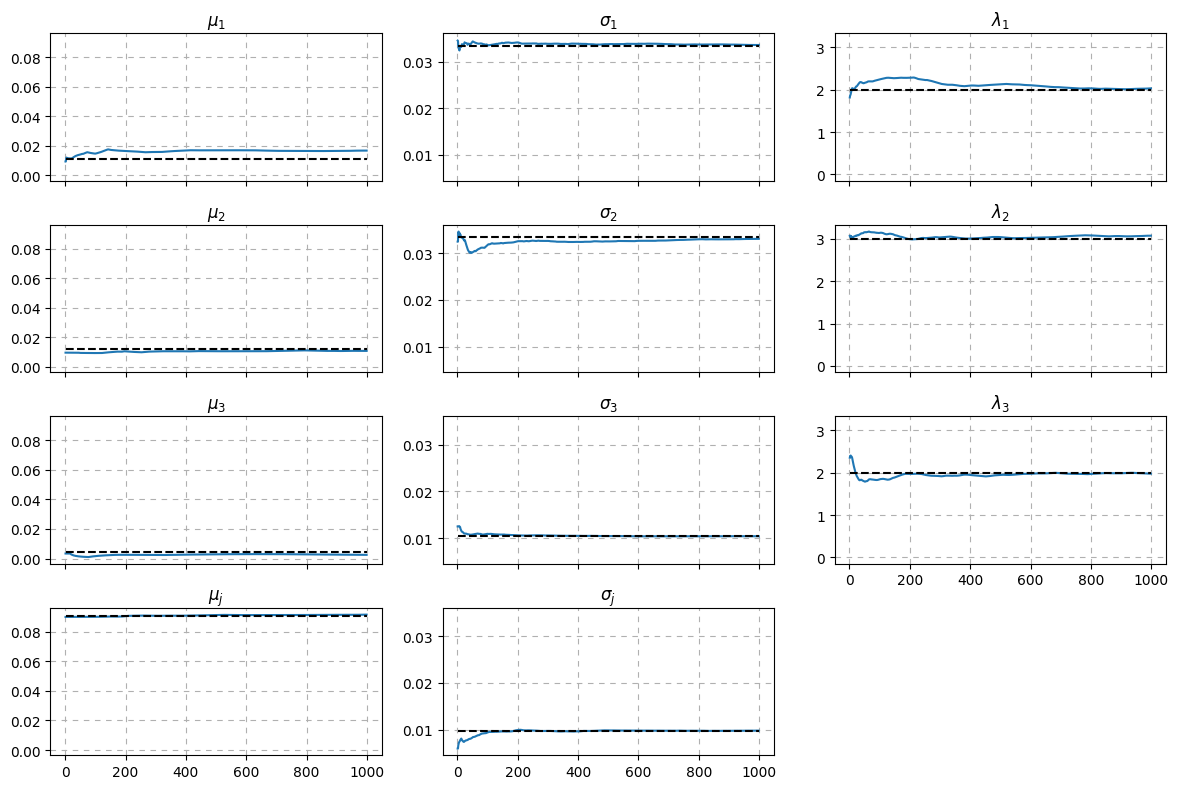

In [9]:
# visualise the first 3 assets only and the jump parameters
fig, ax = plt.subplots(4, 3, figsize = (12, 8), sharey = 'col')

x       = np.arange(1, len(samples) + 1)

for k, (values, truth, title) in enumerate(zip(samples.T, solution, latex)):
    i, j = divmod(k, 3)
    if k == 12: break
    if k >= 9:
        i, j = 3, k % 9
        values = samples[:,j - 2]
        truth  = solution[j - 2]
        title  = latex[j - 2]
    cum_vals = values.cumsum() / x
    if j == 1 or (i, j) == (1, -1):
        cum_vals = 10 ** cum_vals
    ax[i, j].plot(x, cum_vals)
    ax[i, j].hlines(truth, 1, len(samples) + 1, ls = '--', colors = 'k')
    ax[i, j].set_title(title)
    ax[i, j].grid(ls = (0, (5, 5)))
    if k not in range(8, 11):
        ax[i, j].set_xticklabels([])
ax[-1, -1].set_visible(False)

plt.tight_layout()

In [10]:
print('estimate     | pstar(theta|data) | log p(data|theta) |      log p(theta)')
print('-------------+-------------------+-------------------+------------------')
for text, values in zip(['initial', 'mcmc average', 'ground truth'], [theta0, average, log_space]):
    results = ' | '.join(f'{fun(values, data = index, start = start):+17.4e}' for fun in [log_pstar, log_data_likelihood,  log_prior])
    print(f'{text:12s} | {results}')

# we can see that the mcmc obtains a result very close to the ground truth (and obtains a marginally better pstar value)

estimate     | pstar(theta|data) | log p(data|theta) |      log p(theta)
-------------+-------------------+-------------------+------------------
initial      |       -1.2434e+07 |       -1.2434e+07 |       +2.7147e+00
mcmc average |       +2.7268e+03 |       +2.7231e+03 |       +3.7320e+00
ground truth |       +2.7165e+03 |       +2.7128e+03 |       +3.7393e+00
